# Imports

In [1]:
# Import TensorFlow into Colab
import tensorflow as tf
print("TF version:", tf.__version__)

# Import necessary tools
import tensorflow_hub as hub
print("TF Hub version:",hub.__version__)

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

TF version: 2.5.0
TF Hub version: 0.12.0


In [2]:
labels_csv = pd.read_csv('drive/MyDrive/Dog-vision/labels.csv')
labels = labels_csv['breed'].to_numpy()
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

# Neceesary Functions

In [3]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jepg image into numerical Tensor with 3 colour channels (RBG)
  image = tf.image.decode_jpeg(image,channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values(normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our described value(224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [4]:
# Definr the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of images (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # only filepaths(no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X)) 

    # Create (image, label) tuples (this also turns image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [5]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [6]:
# Create a function to load a save model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model form:{model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

# Making Predictions

In [7]:
# Load in the full model
loaded_full_model = load_model("drive/MyDrive/Dog-vision/models/20210602-07021622617377_full-image-set-mobilenetv2-Adam.h5")

Loading saved model form:drive/MyDrive/Dog-vision/models/20210602-07021622617377_full-image-set-mobilenetv2-Adam.h5


In [8]:
# Get custom image filepaths
custom_path =  "drive/MyDrive/Dog-vision/custom/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [9]:
custom_image_paths

['drive/MyDrive/Dog-vision/custom/dog2.jfif',
 'drive/MyDrive/Dog-vision/custom/Screenshot_20210603-125509_Google.png',
 'drive/MyDrive/Dog-vision/custom/Screenshot_20210603-140139_Google.png',
 'drive/MyDrive/Dog-vision/custom/download.jfif']

In [10]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [11]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [12]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['german_shepherd', 'border_collie', 'standard_poodle', 'shih-tzu']

In [13]:
# Get custom images (our unbatchify() function won't work since there aren.t labels..)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

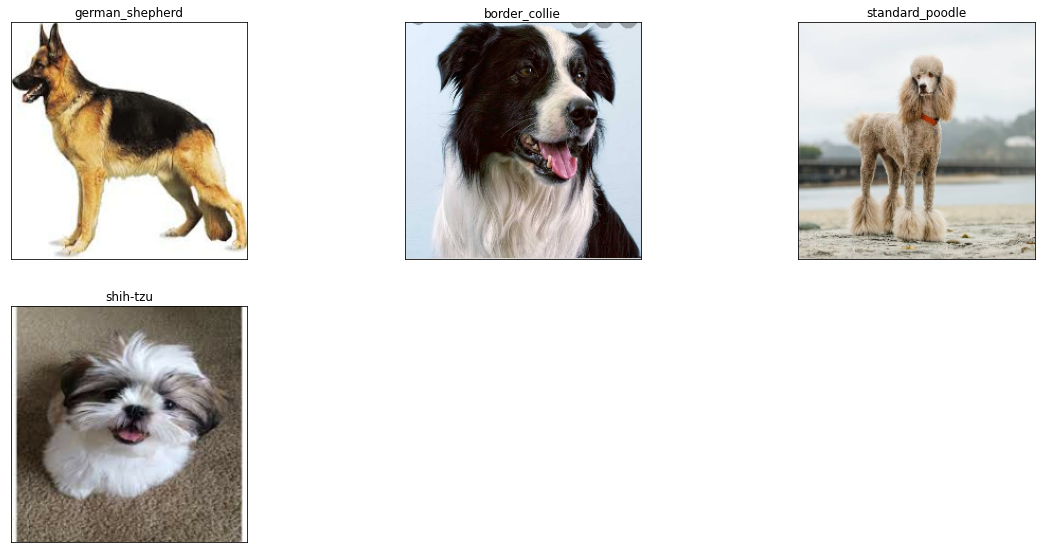

In [14]:
# Check custom images predictions
plt.figure(figsize=(20,20))
for i, image in enumerate(custom_images):
  plt.subplot(len(custom_image_paths),3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)